# Understanding the political agenda:new tools to study of public discourse

**Understanding how political priorities are defined and change is an important problem**. In a context where climate change and public debt are considered priorities, new policies that respect both future and current generations are expected.
Baseline studies are typically used to understand the "state of the art", to which subsequent events and policies can be compared. However, traditional ones are subject to different biases, hampering the results. **Here, we use the concept of <u>"intergenerational justice" and "sustainability"<u> to propose a new method to study awareness**. We find differences between and within stakeholders and topics, and that these differences are impacted by exogenous events.

Considering the topic at hand, and the importance that understanding the political discourse has in societies, in this python notebook the reader will be able to find different analyses focused on newspaper pieces from 2007 until 2019.



# Libraries

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from nltk.stem import WordNetLemmatizer
import re
from nltk.stem import RSLPStemmer
from nltk import word_tokenize
import string
from sklearn.decomposition import PCA
import nltk
import nlpnet
import swifter

%matplotlib inline
plt.style.use('ggplot')

In [191]:
#functions that are transversal to all analyses

def unpack(lists):
    return [i for minilist in lists for i in minilist ]  


# Data import

**"SDD_JI_Artigos"** dataset is a collection with **more than 15k newspaper articles** from  **3 of the newspapers most read in Portugal** (Expresso, Público and Correio da Manhã) from **2008 until 2019**.

In [192]:
dataset=pd.read_excel(r"C:\Users\franco joao\Desktop\Personal files\thesis_master\SDD_JI_Artigos.xlsx")

# Initial Data Treatment

In this initial section, several transversal data treatment techniques were developed to ensure the quality and the usefulness of the data to be analysed.

In [193]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15898 entries, 0 to 15897
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  15898 non-null  datetime64[ns]
 1   title       15898 non-null  object        
 2   lead        15880 non-null  object        
 3   body        15898 non-null  object        
 4   link        15898 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 621.1+ KB


In [194]:
dataset.lead.fillna(" ",inplace=True), dataset.rename(columns={"Unnamed: 0":"Time"}, inplace=True)

(None, None)

In [195]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15898 entries, 0 to 15897
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    15898 non-null  datetime64[ns]
 1   title   15898 non-null  object        
 2   lead    15898 non-null  object        
 3   body    15898 non-null  object        
 4   link    15898 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 621.1+ KB


In [196]:
dataset_cols=dataset.columns
dataset_cols

Index(['Time', 'title', 'lead', 'body', 'link'], dtype='object')

In [197]:
dataset.head()

,Time,title,lead,body,link
0,2007-01-03,Correio da Manhã,É capaz de ser uma brincadeira ritual do Bloco...,"Impresso do site do jornal Correio da manhã, e...",http://www.cmjornal.pt/opiniao/detalhe/lingua-...
1,2007-01-05,"Presidente diz que o país ""não pode descansar""","Na mensagem de ano novo, o Presidente da Repúb...","Na mensagem de ano novo, o Presidente da Repúb...",http://www.expresso.pt/africa/presidente-diz-q...
2,2007-01-07,Mercado accionista continua suportado,"Ricardo Valente, presidente da Personal Value ...","Impresso do site do jornal Correio da manhã, e...",http://www.cmjornal.pt/economia/detalhe/mercad...
3,2007-01-08,Falham investimentos portugueses,"""Moçambique não tem petróleo, logo não é tão i...","""Moçambique não tem petróleo, logo não é tão i...",http://www.expresso.pt/africa/falham-investime...
4,2007-01-12,Nótulas sobre o uso e desuso do guarda-chuva,Roupa para lavar,O Mundo divide-se em duas partes: os fãs do gu...,http://www.expresso.pt/blogues/blog_roupa_para...


In [198]:
#with the full case in lowercases we can simplified token search
for column in dataset_cols[[1,2,3]]:
    dataset[column]=[*map(str.lower,dataset[column])]

In [199]:
dataset.loc[:,"year"]=pd.DatetimeIndex(dataset.Time).year
dataset.loc[:,"month"]=pd.DatetimeIndex(dataset.Time).month


In [200]:
def trimesters(dataset):

    trimester_JI=[]
    for month in dataset.month:
        if month<=3:
            trimester_JI.append(1)
        elif month >=10:
            trimester_JI.append(4)
        elif (month >=4 and month <=6):
            trimester_JI.append(2)
        else:
            trimester_JI.append(3)

    dataset["trimester"]=trimester_JI
    return dataset

In [201]:
dataset=trimesters(dataset)
dataset=trimesters(dataset)

It is important to ensure that **all the data is from articles published in Portugal** to ensure the quality of the data used. It was **considered that if the website is not ".pt" that it was not published in Portugal**.

In [202]:
dataset[~dataset.link.str.contains(".pt")].link

11497    http://publico.uol.com.br/lifestyle/artigo/est...
Name: link, dtype: object

With this, it is possible to conclude that only 1 observation can be considered as not published in Portugal.

In [203]:
dataset=dataset[dataset.link.str.contains(".pt")]

In [204]:
# data to be used throughout all the analyses to come
data=dataset.copy()
columns=dataset_cols[[1,2,3]] #these are the columns that have text 

After several data treatment techniques, the **pandas DataFrame “data” will be the base of the future analyses**.

# Tokenizer

Several analyses taken further will require the tokenization of the several newspaper articles, hence the **tokenization techniques required will be applied in this section** to optimize the code.


**Several limitations** are recognized, as nltk as **trained not only from Portuguese from Portugal**, but in part in texts from Portuguese from Brazil. Although the sentence construction can be different sometimes, **it is believed that the tokenization process would not be highly impacted**.


In [205]:
data.loc[:,"body_tokens"]=data.body.swifter.apply(word_tokenize)

# Datasets of Sustainability (SDD) and Intergenerational Justice (JI)

In this section the different observations will be **classified as related with sustainability or intergenerational Justice**, **<u>depending on the frequency of keywords that were selected leveraging internal content knowledge<u>**.
  
**The presence of the topics in only one component** (body, title or lead) in the article **is enough to make the classification**, <u> minimizing false negative errors</u>. It is assumed that these terms are only used in cases strongly linked with the topics in being studied and so, even one occurrence is a strong indicator of the topic of the article.

In [206]:
SDD="sustentável|insustentável|sustentabilidade|insustentabilidade|sustentar"
JI="interger|gerações vindouras|gerações futuras|geração futura|próxima geração|justiça entre gerações|geração vindoura|geração seguinte|gerações presentes|entre gerações|próximas gerações|gerações mais jovens| novas gerações| gerações distintas| próximas gerações"

In [207]:
data.columns

Index(['Time', 'title', 'lead', 'body', 'link', 'year', 'month', 'trimester',
       'body_tokens'],
      dtype='object')

In [208]:
columns_to_remove_after=[]
for column in columns:
    data[column + "SDD"]=data[column].str.contains(SDD)
    data[column + "JI"]=data[column].str.contains(JI)
    columns_to_remove_after.append(column+"SDD")
    columns_to_remove_after.append(column+"JI")

In [209]:
#To understand which news mention at least one time the SDD or JI topic
data["SDD"]=data.titleSDD|data.leadSDD|data.bodySDD
data["JI"]=data.titleJI|data.leadJI|data.bodyJI
data.drop(columns_to_remove_after,axis=1,inplace=True)
data.head()

,Time,title,lead,body,link,year,month,trimester,body_tokens,SDD,JI
0,2007-01-03,correio da manhã,é capaz de ser uma brincadeira ritual do bloco...,"impresso do site do jornal correio da manhã, e...",http://www.cmjornal.pt/opiniao/detalhe/lingua-...,2007,1,1,"[impresso, do, site, do, jornal, correio, da, ...",False,True
1,2007-01-05,"presidente diz que o país ""não pode descansar""","na mensagem de ano novo, o presidente da repúb...","na mensagem de ano novo, o presidente da repúb...",http://www.expresso.pt/africa/presidente-diz-q...,2007,1,1,"[na, mensagem, de, ano, novo, ,, o, presidente...",True,False
2,2007-01-07,mercado accionista continua suportado,"ricardo valente, presidente da personal value ...","impresso do site do jornal correio da manhã, e...",http://www.cmjornal.pt/economia/detalhe/mercad...,2007,1,1,"[impresso, do, site, do, jornal, correio, da, ...",True,False
3,2007-01-08,falham investimentos portugueses,"""moçambique não tem petróleo, logo não é tão i...","""moçambique não tem petróleo, logo não é tão i...",http://www.expresso.pt/africa/falham-investime...,2007,1,1,"[``, moçambique, não, tem, petróleo, ,, logo, ...",True,False
4,2007-01-12,nótulas sobre o uso e desuso do guarda-chuva,roupa para lavar,o mundo divide-se em duas partes: os fãs do gu...,http://www.expresso.pt/blogues/blog_roupa_para...,2007,1,1,"[o, mundo, divide-se, em, duas, partes, :, os,...",False,True


In [210]:
#count number of observations that satisfy conditions
len(data.SDD[data.SDD==True]), len(data.SDD[data.SDD==False]), len(data.SDD[data.JI==True]),len(data.SDD[data.JI==False])

(13916, 1981, 2148, 13749)

### Section 1 - SDD and JI historical time series evolution on traditional media

In [211]:
#to remove unnecessary columns
data1=data.copy().drop(["body_tokens","title","lead","body"],axis=1)

In [212]:
data1.columns

Index(['Time', 'link', 'year', 'month', 'trimester', 'SDD', 'JI'], dtype='object')

The goal of this first section is to **understand how frequently and historically intergenerational and sustainability-related topics have been mentioned** in the traditional media, focusing on newspapers. 



It was considered that the **website of the online publication is related to the newspaper responsible** for the article. Hence after identifying that the 23 first characters of the website are enough to identify the responsible website, these characters were selected to then classify each article as related to a specific newspaper.

In this case, it will be possible to conclude that there **were considered 3 major newspapers**. This serves as a <u>cross check analysis</u> considering that it was known a priori this fact.

In [213]:
#Different newspapers finder

links_support=pd.DataFrame(data.link)

def left_text(text,characters):
    return text[:characters]

links_support["simple_link"]=links_support.link.apply(lambda x: left_text(x,23)) # as it seems that until character 23 it is possible to identify the name of the news paper
newspapers=list(links_support.simple_link.unique())
newspapers

['http://www.cmjornal.pt/',
 'http://www.expresso.pt/',
 'https://www.publico.pt/',
 'https://acervo.publico.',
 'http://lifestyle.public']

In [214]:
newspapers

['http://www.cmjornal.pt/',
 'http://www.expresso.pt/',
 'https://www.publico.pt/',
 'https://acervo.publico.',
 'http://lifestyle.public']

In [215]:
links_support[(links_support.simple_link==newspapers[3])|(links_support.simple_link==newspapers[4])].link
#Important to remark that althoguh some links no longer reveal the associated article,
#it is still possible to identify that it was link to the afterwards classified article

9656     https://acervo.publico.pt/economia/noticia/pen...
9816     https://acervo.publico.pt/sociedade/noticia/25...
10485    https://acervo.publico.pt/sociedade/noticia/po...
10717    https://acervo.publico.pt/economia/noticia/um-...
10718    https://acervo.publico.pt/economia/noticia/uma...
10721    https://acervo.publico.pt/economia/noticia/ha-...
10988    https://acervo.publico.pt/culturaipsilon/notic...
11186    https://acervo.publico.pt/ecosfera/noticia/na-...
11667    https://acervo.publico.pt/culturaipsilon/notic...
12897    http://lifestyle.publico.pt/noticias/370964_de...
15549    https://acervo.publico.pt/ecosfera/o-dia-da-te...
Name: link, dtype: object

In [216]:
#the clasffication in the next line of code was developed after operning the respective links
newspapers_dic=dict(zip(newspapers,["CMJornal","Expresso","Publico","Publico","Publico","Publico"]))
newspapers_titles=["Expresso","Publico","CMJornal"]

After identifying the unique 23 first characters in the websites and linking them to the different newspaper names selected manually, it is **now possible to classify each observation considering the newspaper responsible for the respective news
publication**.

In [217]:
def article_newspaper(dataset,column,newspapers_dic,characters):
    aux=dataset.copy()
    aux["aux_"]=aux[column].apply(lambda x:left_text(x,characters))
    results=[newspapers_dic[i] for i in aux.aux_]
    return results

In [218]:
data1.loc[:,"newspaper"]=article_newspaper(data,"link",newspapers_dic,23)

Now, since we only want to analyses articles related to JI or SDD, the data needs to be filtered to account for this restriction.

In [219]:
data_SDD=data1[data1.SDD].copy()
data_JI=data1[data1.JI].copy()


In [220]:
#to confirm that the selection is correct
aux=data1.loc[:,["SDD","JI"]].sum(axis=1).value_counts()
aux.loc[1]+aux.loc[2]*2==len(data_SDD)+len(data_JI)

True

To have a more general notion of the time series related with the mention to the topics selected, while <u>reducing the granularity levels</u> associated with daily observations, the **time series will be developed on top of trimestral data**.

In [221]:
#data to plot

def newspapers_plot(data,fil1,fil2,col1):
    newspapers_data_trimester=pd.concat([pd.get_dummies(data.loc[:,col1]),data.loc[:,[fil1,fil2]]],axis=1)
    newspapers_data_trimester["newspapers_total"]=newspapers_data_trimester.iloc[:,:3].sum(axis=1)
    newspapers_plot=newspapers_data_trimester.groupby([fil1,fil2]).sum()
    return newspapers_plot

data_JI_plot=newspapers_plot(data_JI,"year","trimester","newspaper")
data_SDD_plot=newspapers_plot(data_SDD,"year","trimester","newspaper")

In [222]:
#cross check to see if there was an error
data_SDD.newspaper.unique(),data_JI.newspaper.unique()

(array(['Expresso', 'CMJornal', 'Publico'], dtype=object),
 array(['CMJornal', 'Expresso', 'Publico'], dtype=object))

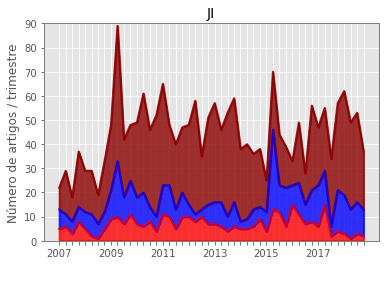

In [223]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, sharey=False)

indexes=[]
for year in data_JI_plot.reset_index().year:
    if (year not in indexes and year%2==1):
        indexes.append(year)
    else:
        indexes.append(" ")

#put the plot's shape grey
for position in ["bottom","top","right","left"]:
    ax1.spines[position].set_color('grey')

#plot the data 
data_JI_plot.iloc[:,:3].plot.area(color=["red","blue","darkred"],ax=ax1,stacked=True,linewidth=2,alpha=0.8)

#arrangements on axis and title
ax1.set(title="JI",ylabel="Número de artigos / trimestre", xlabel=" ")
plt.xticks(np.arange(48),indexes)
plt.ylim([0,90])
ax1.get_legend().remove()

plt.show()



In [224]:
#cross check

data_JI_plot.newspapers_total.sum()==len(data_JI),data_SDD_plot.newspapers_total.sum()==len(data_SDD)

(True, True)

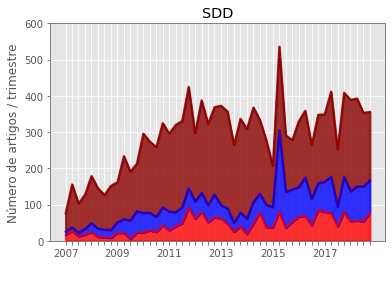

In [225]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, sharey=False)

indexes=[]
for year in data_SDD_plot.reset_index().year:
    if (year not in indexes and year%2==1):
        indexes.append(year)
    else:
        indexes.append(" ")

#put the plot's shape grey
for position in ["bottom","top","right","left"]:
    ax1.spines[position].set_color('grey')

#plot the data 
data_SDD_plot.iloc[:,:3].plot.area(color=["red","blue","darkred"],ax=ax1,stacked=True,linewidth=2,alpha=0.8)

#arrangements on axis and title
ax1.set(title="SDD",ylabel="Número de artigos / trimestre", xlabel=" ")
plt.xticks(np.arange(48),indexes)
plt.ylim([0,600])
ax1.get_legend().remove()

plt.show()



To better grasp the relevance of each newspaper, a global absolute frequency analysis was also developed.

In [226]:
graph_data_hbar_SDD=pd.DataFrame(data_SDD_plot.sum().iloc[:3]).sort_values(by=0)

graph_data_hbar_JI=pd.DataFrame(data_JI_plot.sum().iloc[:3]).sort_values(by=0)


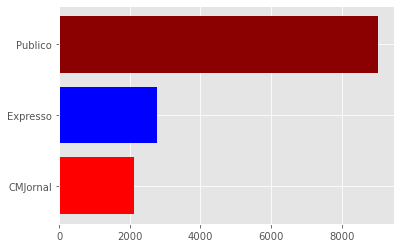

In [227]:
plt.barh(graph_data_hbar_SDD.index,graph_data_hbar_SDD[0],color=["red","blue","darkred"])
plt.show()

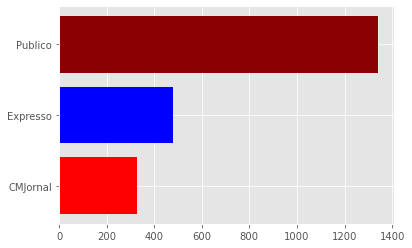

In [228]:
plt.barh(graph_data_hbar_JI.index,graph_data_hbar_JI[0],color=["red","blue","darkred"])
plt.show()

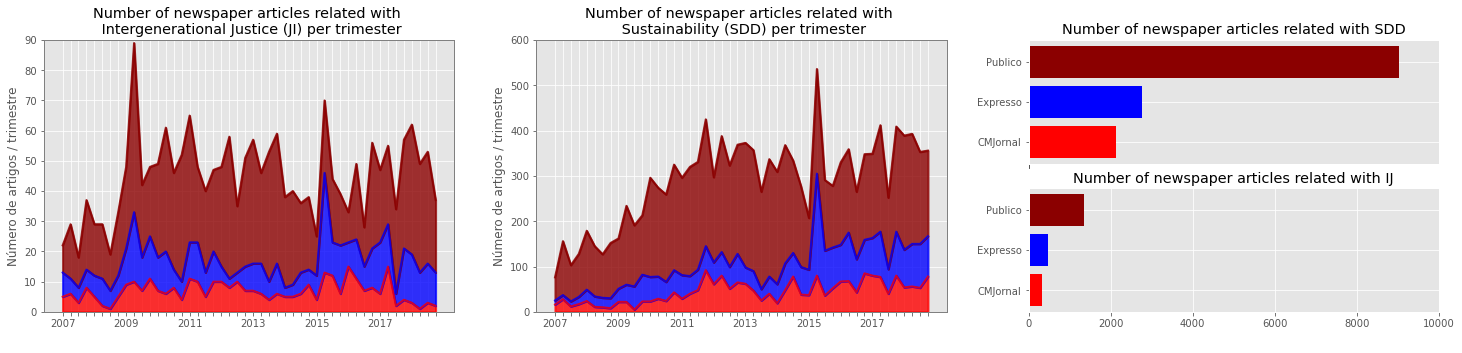

In [229]:
fig, ax=plt.subplots(nrows=2,ncols=3,figsize=(25,5))

#plot1

ax[0,0] = plt.subplot(1,3,1)


#put the plot's shape grey
for position in ["bottom","top","right","left"]:
    ax[0,0].spines[position].set_color('grey')

#plot the data 
data_JI_plot.iloc[:,:3].plot.area(color=["red","blue","darkred"],ax=ax[0,0],stacked=True,linewidth=2,alpha=0.8)

#arrangements on axis and title
ax[0,0].set(title="Number of newspaper articles related with \n Intergenerational Justice (JI) per trimester",ylabel="Número de artigos / trimestre", xlabel=" ")
plt.xticks(np.arange(48),indexes)
plt.ylim([0,90])
ax[0,0].get_legend().remove()

#----------------------------------------------------------------------------------------------------------------

#plot2

ax[0,1] = plt.subplot(1,3,2)

#put the plot's shape grey
for position in ["bottom","top","right","left"]:
    ax[0,1].spines[position].set_color('grey')
    
#plot the data 
data_SDD_plot.iloc[:,:3].plot.area(color=["red","blue","darkred"],ax=ax[0,1],stacked=True,linewidth=2,alpha=0.8)    

#arrangements on axis and title    
ax[0,1].set(title="Number of newspaper articles related with \n Sustainability (SDD) per trimester",ylabel="Número de artigos / trimestre", xlabel=" ")
plt.xticks(np.arange(len(data_SDD_plot)),indexes)
plt.ylim([0,600])
ax[0,1].get_legend().remove()

#----------------------------------------------------------------------------------------------------------------

#plot3.1

ax[1,2] = plt.subplot(2,3,3)
#plot the data
ax[1,2].barh(graph_data_hbar_SDD.index,graph_data_hbar_SDD[0],color=["red","blue","darkred"])
#arregements on axis and title
ax[1,2].set(title="Number of newspaper articles related with SDD")
plt.xticks(np.arange(5),[" "," "," "," "," "])
plt.xlim([0,10000])

#----------------------------------------------------------------------------------------------------------------

#plot3.2

ax[0,2] = plt.subplot(2,3,6)
#plot the data
ax[0,2].barh(graph_data_hbar_JI.index,graph_data_hbar_JI[0],color=["red","blue","darkred"])
#arregements on axis and title
ax[0,2].set(title="Number of newspaper articles related with IJ")
plt.xlim([0,10000])
#----------------------------------------------------------------------------------------------------------------

plt.show()



**Conclusion** - The evolution regarding the number of articles related to SDD or JI per trimester has not been constant since 2007, we a clear greater mention to JI during 2009 and SDD during 2015. Moreover, it is possible to observe that number of articles mentioning sustainability increased since 2007 potentially revealing a greater awareness of newspaper on the topic. Moreover, Publico reveals as the major newspaper approaching both topics since 2007.

### Section 2 - Sustainability, Intergenerational Justice and other important topics for society

Considering that the topics of **SDD and JI can be applied in different contexts (e.g.: environment, debt, health, among others)**, it is important to understand within the observations classified as JI or SDD related, the topics that are related with. This is the focus of the second section.

In [230]:
data2=data[(data.SDD)|(data.JI)]
data2.head()

,Time,title,lead,body,link,year,month,trimester,body_tokens,SDD,JI
0,2007-01-03,correio da manhã,é capaz de ser uma brincadeira ritual do bloco...,"impresso do site do jornal correio da manhã, e...",http://www.cmjornal.pt/opiniao/detalhe/lingua-...,2007,1,1,"[impresso, do, site, do, jornal, correio, da, ...",False,True
1,2007-01-05,"presidente diz que o país ""não pode descansar""","na mensagem de ano novo, o presidente da repúb...","na mensagem de ano novo, o presidente da repúb...",http://www.expresso.pt/africa/presidente-diz-q...,2007,1,1,"[na, mensagem, de, ano, novo, ,, o, presidente...",True,False
2,2007-01-07,mercado accionista continua suportado,"ricardo valente, presidente da personal value ...","impresso do site do jornal correio da manhã, e...",http://www.cmjornal.pt/economia/detalhe/mercad...,2007,1,1,"[impresso, do, site, do, jornal, correio, da, ...",True,False
3,2007-01-08,falham investimentos portugueses,"""moçambique não tem petróleo, logo não é tão i...","""moçambique não tem petróleo, logo não é tão i...",http://www.expresso.pt/africa/falham-investime...,2007,1,1,"[``, moçambique, não, tem, petróleo, ,, logo, ...",True,False
4,2007-01-12,nótulas sobre o uso e desuso do guarda-chuva,roupa para lavar,o mundo divide-se em duas partes: os fãs do gu...,http://www.expresso.pt/blogues/blog_roupa_para...,2007,1,1,"[o, mundo, divide-se, em, duas, partes, :, os,...",False,True


In [231]:
#cross check

data2.loc[:,["SDD","JI"]].sum(axis=1).value_counts()
#as they are always more than 1, it is true that all observations are either classified as SDD or JI related


1    14936
2      564
dtype: int64

In [232]:
#cross check
len(data2)==data1.loc[:,["SDD","JI"]].sum(axis=1).value_counts().loc[[1,2]].sum()

True

To optimize the classification process, several keywords were considered. This **selection was made manually with trial and error**. It might be <u>some false negatives, but after careful manual consideration, these were considered the key ones</u>.

In [233]:
environment=["ambiente","planeta","terra","água",
          "floresta","híbrido","incêndio","desfloresta","solo","erosão","reciclar","reutilizar"]
debt=["dívida","juros"]
education=["educação","escola","estudante","alunos","professores"]
health=["saúde","S.N.S"]

social_security=["pensão","segurança social", "S.S", "S.S.","SS", "pensões","reformado","reformada",
                  "pensionistas","contribuinte","discontos","rendimentos"]



others=["agricultura","agricultores","agrícola","polícia","TAP","RTP","RDP"]
politics=["assembleia da república","governo","ministro","partido"]

topics_name=["environment","debt","education","health","social_security","others","politics"]

topics=[environment,debt,education,health,social_security,others,politics]

The function values_per_instances was developed to classify each article. 

In [234]:
#Key functions that will be used

def values_per_instances(instance,lists,lists_name,number):
    lists_counter=np.zeros(len(lists_name),dtype=int)
    result=[]
    for index_list,list_ in enumerate(lists):
        for word in list_:
            if instance.count(str(word))!=0:
                lists_counter[index_list]+=instance.count(str(word))
        if lists_counter[index_list]>=number:
            result.append(lists_name[index_list])
    return result

For an article to be classified as environment, health, etc. it is needed to **appear in each article at least two examples of words from that group**, being them unique or not. This reduces the levels of noise in the classification.

In [235]:
data_topics=data2.body.swifter.apply(lambda x:values_per_instances(x,topics,topics_name,2))

In [236]:
#cross check
len(data_topics)==len(data2)

True

To convert the prior output into a dataframe with dummy columns the update_database was created.

In [237]:
def update_database(content,lists_name):
        database=pd.DataFrame(index=np.arange(len(content)),columns=lists_name).fillna(0)
        for index_instance,instance in enumerate(content):
            for index_item,item in enumerate(instance):
                if item in lists_name:
                    database.loc[index_instance,item]+=1
        return database

In [238]:
data_topics_count=update_database(data_topics,topics_name)


In [239]:
politics_info=data_topics_count.politics
#we remove the values from the politica column as politics is not considered as a key topic
data_topics_count["total"]=data_topics_count.sum(axis=1)-data_topics_count.politics
data_topics_count["year"]=data2.year


In [240]:
#cross check
len(data_topics_count)==len(data_topics)

True

In [241]:
data_topics_count

,environment,debt,education,health,social_security,others,politics,total,year
0,0,0,1,0,0,0,0,1,2007.0
1,0,0,0,0,0,0,0,0,2007.0
2,0,0,0,0,0,0,0,0,2007.0
3,0,0,0,0,0,0,0,0,2007.0
4,0,0,0,0,0,0,1,0,2007.0
...,...,...,...,...,...,...,...,...,...
15495,1,0,0,0,0,0,0,1,2018.0
15496,0,0,0,0,0,0,0,0,2018.0
15497,0,0,0,0,1,0,0,1,2018.0
15498,0,0,0,0,1,0,1,1,2018.0


In [242]:
#cross check
(data_topics_count.sum(axis=1)).value_counts().sum()==data_topics.value_counts().sum()


True

Now having a dataframe with the respective observations related to JI or SDD classified as related to one specific topic, the analyses can be continued.

In [243]:
important_cols=data_topics_count.columns

In [244]:
datatopics=pd.merge(data2.reset_index().drop("index",axis=1).reset_index(),data_topics_count.reset_index(),
                    on="index",suffixes=("","_y"))
datatopics.drop(["year_y"],axis=1,inplace=True)


In [245]:
#cross check
len(datatopics)==len(data_topics_count)

True

In [246]:
#todos os artigos classificados
fig_=datatopics.loc[:,unpack([["Time","year","total"],topics_name])]
fig_.head()

,Time,year,total,environment,debt,education,health,social_security,others,politics
0,2007-01-03,2007,1,0,0,1,0,0,0,0
1,2007-01-05,2007,0,0,0,0,0,0,0,0
2,2007-01-07,2007,0,0,0,0,0,0,0,0
3,2007-01-08,2007,0,0,0,0,0,0,0,0
4,2007-01-12,2007,0,0,0,0,0,0,0,1


In [247]:
#cross check
len(fig_)==len(datatopics)

True

In [248]:
len(data_topics_count), len(datatopics)

(15500, 15500)

In [249]:
# as the goal is to understand out of the articles related with JI/SDD and with at least one the six topics (excluding politica)
totals=data_topics_count[data_topics_count.total!=0].groupby("year").sum().total
not_pie_chart=[]
for tema_index,tema in enumerate(topics_name):
    if tema == "politics":
        continue
    else:
        fig5tema=fig_[fig_.loc[:,tema]!=0].groupby("year").sum()

        
        tema_data=fig5tema.loc[:,[tema,"politics"]]

        aux=round(tema_data.div(totals,axis=0)*100,2)

        not_pie_chart.append(aux.fillna(0))


In [250]:
#cross check
topics_name[:len(topics_name)-1]==fig5tema.columns[1:len(fig5tema.columns)-1]

array([ True,  True,  True,  True,  True,  True])

In [251]:
#cross check for the next block of code
for index_fig,fig in enumerate(not_pie_chart):
    print(not_pie_chart[index_fig].columns[1]==topics_name[index_fig])

False
False
False
False
False
False


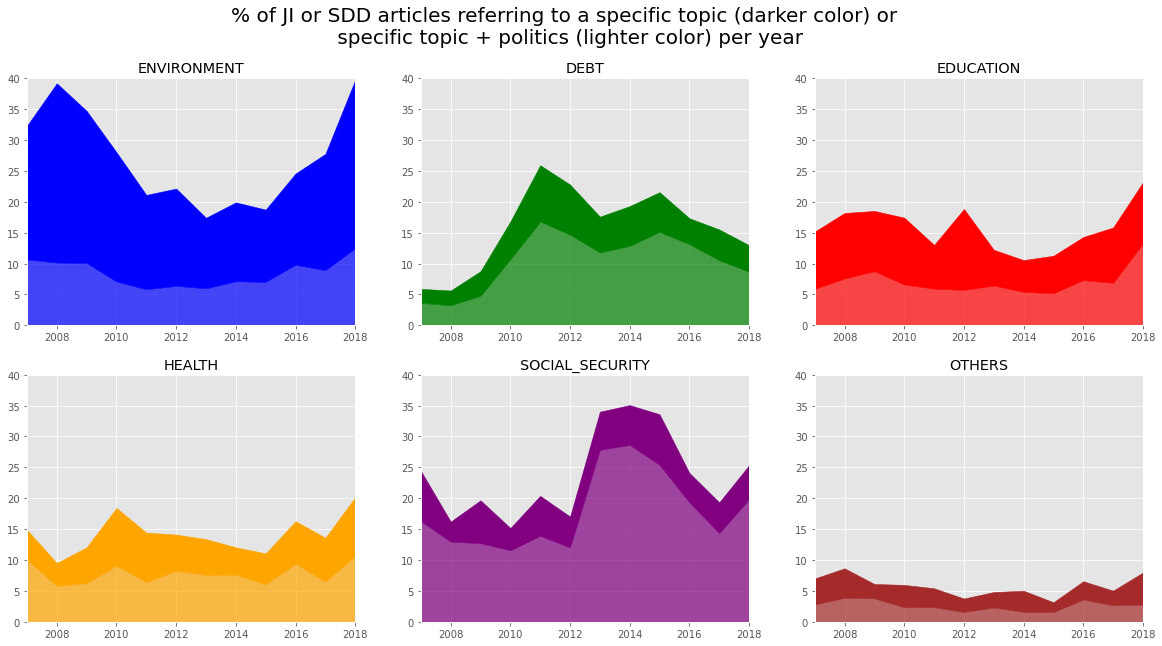

In [252]:
color=['blue',"green","red","orange","purple","brown"]

figs,ax=plt.subplots(nrows=2,ncols=3,figsize=(20,10))

ax=[j for i in ax for j in i]

x_axis=np.arange(2007,2019)
lower_y=0 

for index_fig,fig in enumerate(not_pie_chart[:6]):
        
        higher_y=not_pie_chart[index_fig].loc[:,topics_name[index_fig]]
        medium_y=not_pie_chart[index_fig].loc[:,"politics"]
        
        ax[index_fig].fill_between(x=x_axis,y1=medium_y,y2=higher_y,color=color[index_fig])
        ax[index_fig].fill_between(x=x_axis,y1=lower_y,y2=medium_y,color=color[index_fig],alpha=0.7)
        ax[index_fig].set_xlim([2007, 2018])        
        ax[index_fig].set_ylim([0, 40])
        ax[index_fig].set_title(topics_name[index_fig].upper())
        
figs.suptitle("% of JI or SDD articles referring to a specific topic (darker color) or \n specific topic + politics (lighter color) per year", fontsize=20)
        
plt.show()

Regarding the pie chart, a new total needs to be calculated as now the graph plots the number of total articles per topic over the total number of articles, not the total yearly number of articles

In [253]:
#all classified articles
classification_total=totals.sum()


In [254]:
data_topics_count.sum(axis=0)

environment            2797.0
debt                   1879.0
education              1676.0
health                 1556.0
social_security        2655.0
others                  598.0
politics               7111.0
total                 11161.0
year               30442299.0
dtype: float64

In [255]:
pie_chart=data_topics_count.sum(axis=0).loc[topics_name].drop("politics",axis=0)/classification_total*100
pie_chart

environment        25.717175
debt               17.276572
education          15.410077
health             14.306730
social_security    24.411548
others              5.498345
dtype: float64

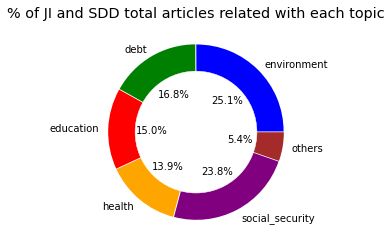

In [256]:
plt.pie(pie_chart,labels=pie_chart.index, explode=[0.01,0.01,0.01,0.01,0.01,0.01],autopct='%1.1f%%',pctdistance=0.5,
       colors=['blue',"green","red","orange","purple","brown"])
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("% of JI and SDD total articles related with each topic")
plt.show()

<ipython-input-257-5347b518a4fa>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[fig].set_yticklabels(['{:,.2%}'.format(x) for x in vals/100])
<ipython-input-257-5347b518a4fa>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[fig].set_xticklabels([' ' for x in vals/100])
<ipython-input-257-5347b518a4fa>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[fig].set_yticklabels([' ' for x in vals/100])


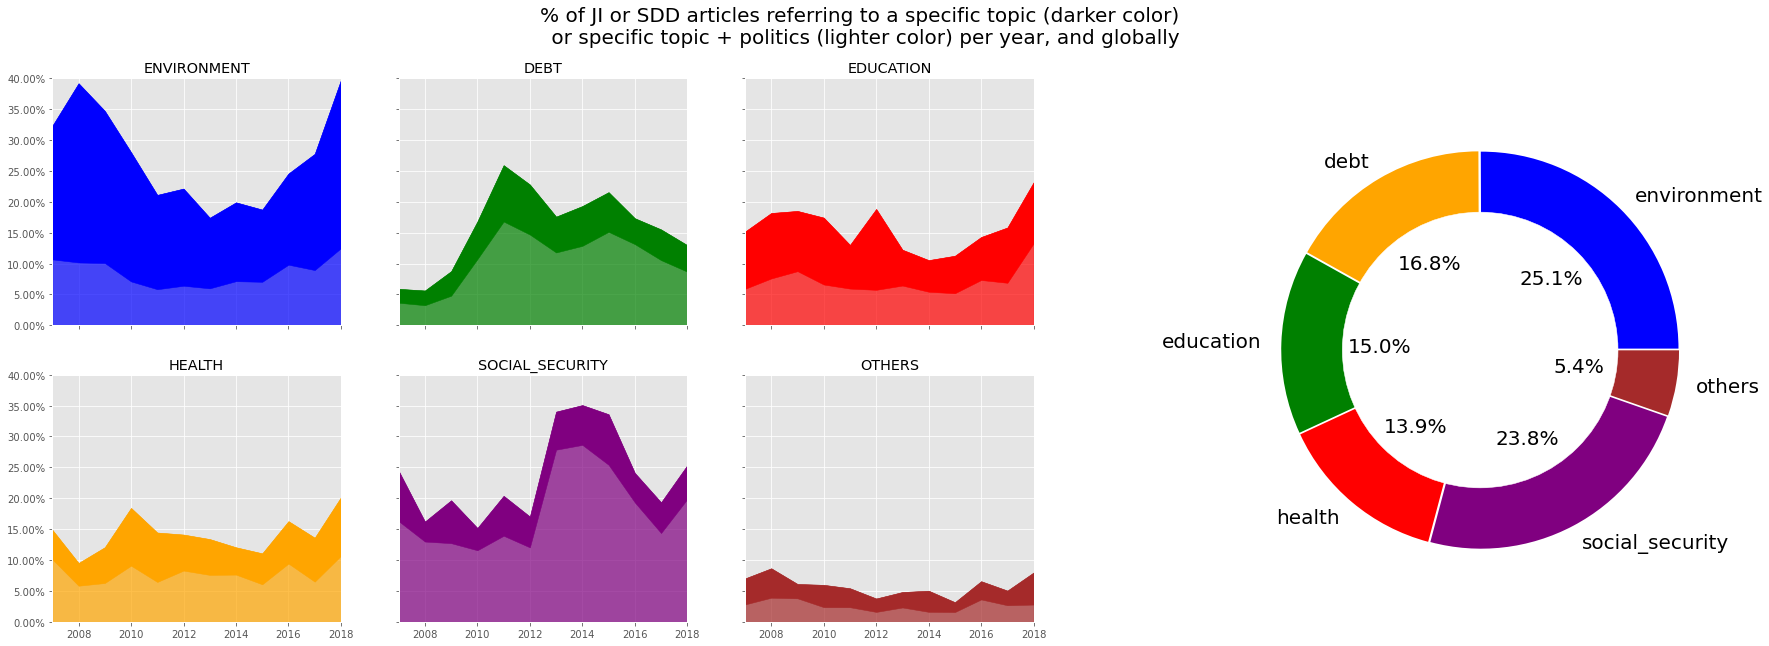

In [257]:

figs,ax=plt.subplots(nrows=2,ncols=5,figsize=(30,10))

color=['blue',"green","red","orange","purple","brown"]

ax=[j for i in ax for j in i]

#pie chart

ax[3]=plt.subplot(1,3,3)
#plot graph
ax[3].pie(pie_chart,labels=pie_chart.index, explode=[0.01,0.01,0.01,0.01,0.01,0.01],autopct='%1.1f%%',pctdistance=0.5,
       colors=['blue',"orange","green","red","purple","brown"],textprops={'fontsize': 20})

my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()

p.gca().add_artist(my_circle)

#----------------------------------------------------------------------------------------------------------------------

#line graphs

x_axis=np.arange(2007,2019)

for index_fig,fig in enumerate([0,1,2,5,6,7]):
    
    #prepare data to be plotted
    y_higher=not_pie_chart[index_fig].iloc[:,1]
    y_medium=not_pie_chart[index_fig].iloc[:,0]
    y_lower=0
    
    #plot data
    ax[fig].fill_between(x=x_axis,y1=y_medium,y2=y_higher,color=color[index_fig])
    ax[fig].fill_between(x=x_axis,y1=0,y2=y_medium,color=color[index_fig],alpha=0.7)
    ax[fig].set_xlim([2007, 2018])
    ax[fig].set_ylim([0, 40])
    
    #arregements on axis 
    if (fig==5) | (fig==0):
        #put y axis in percentage
        vals = ax[fig].get_yticks()
        ax[fig].set_yticklabels(['{:,.2%}'.format(x) for x in vals/100])
    if (fig in [0,1,2]):
        #remove x axis
        vals= ax[fig].get_xticks()
        ax[fig].set_xticklabels([' ' for x in vals/100])
    if (fig in [1,2,6,7]):
        #remove y axis
        vals= ax[fig].get_yticks()
        ax[fig].set_yticklabels([' ' for x in vals/100])
        
    ax[fig].set_title(topics_name[index_fig].upper())
    
figs.suptitle ("% of JI or SDD articles referring to a specific topic (darker color) \n or specific topic + politics (lighter color) per year, and globally",fontsize=20)       
        

plt.subplots_adjust(wspace=0.2)
        
plt.show()

**Conclusion** - Considering the selection made, the evolution of the percentage of articles approaching environment and JI or SDD changed from 2007 until 2018, facing a U-shape evolution with the decrease starting after 2008. In 2008-2009, Portugal started to face the effects of the global financial crisis that might have refocused the newspapers attention to other more financial related topics as debt or social security-related topics. Further analyses on this potential causation relationship should be developed.

# Section 3 - Newspaper articles developed by newspaper 

Although each observation was classified as related with JI or SDD, and with one of the 7 topics (including politics), the **previous classification was developed considering our understanding of the topic at hand.**

Nevertheless, **each newspaper also classifies each article as related to a specific topic determined by the newspaper**. Hence, the **next objective is to extract this classification from the link**.

The focus of the next section is two understand what most frequent classifications realized by newspapers.


In [258]:
data3=data1.copy()

In [259]:
data3.columns

Index(['Time', 'link', 'year', 'month', 'trimester', 'SDD', 'JI', 'newspaper'], dtype='object')

In [260]:
links=data3.loc[:,["link","newspaper","SDD","JI"]]
links.head()

,link,newspaper,SDD,JI
0,http://www.cmjornal.pt/opiniao/detalhe/lingua-...,CMJornal,False,True
1,http://www.expresso.pt/africa/presidente-diz-q...,Expresso,True,False
2,http://www.cmjornal.pt/economia/detalhe/mercad...,CMJornal,True,False
3,http://www.expresso.pt/africa/falham-investime...,Expresso,True,False
4,http://www.expresso.pt/blogues/blog_roupa_para...,Expresso,False,True


The dataset reveals **two irregularities** that complicate the process of category extraction:

<u>**1**</u>- **Some articles are classified with one category and one sub-category, while others only have one category**. E.g., Publico articles possess 2 descriptive categories that are mandatory to obtain. Therefore, for some of the articles, the procedure needs to be done twice. 

<u>Example below</u>: As it can be observed in the 2 next observations some links have one associated category (in the first output is "africa") while others have one category and one sub-category (in the second output the link has "economia" and "noticia")

In [261]:
links.link[1]

'http://www.expresso.pt/africa/presidente-diz-que-o-pais-nao-pode-descansar=f108412'

In [262]:
links.link[13]

'https://www.publico.pt/2007/01/31/economia/noticia/funcao-publica-governo-admite-nao-aumentar-penalizacao-das-reformas-antecipadas-1284147'

<u>**2**</u>- **Some links after the ".pt" possess a date**, therefore to select the categories after the date, these dates will need to be avoided. 

To extract "avoid" the second irregularities constraints related to the after link date, the function avoid_dates was created.

In [263]:
def avoid_dates(instance,end):
    for i in range(1,4):
        index2=instance[end+1:].index("/") #the +1 is included in order to avoid the / discovered previously
        end+=index2+1
        category=instance[end-index2:end]
    return category,end

To extract articles' categories the category_after_hash function was developed.

In [264]:
def category_after_hash(instance,index_start):
    
    #This is to  identify the index where the algorithm starts searching for the category
    index_first_hash=instance[index_start:].index("/")
    beginning=index_start+index_first_hash+1 #the +1 is not to include the /
    
    #When applying the function for the second time there is the possibility that there not 
    #/ again therefore we need to account for this situations by using the first try:
   
    
    try:
        index_second_hash=instance[beginning:].index("/")
        end=beginning+index_second_hash 
        category=instance[beginning:end]
        
        try :
             #Regarding the problem with the sub-category, it only occurs when the link possesses the date after the .pt/ ,
            #for example. That is why we need to see if the problem was returning an integer, because 
            #if did we need to continue to seach for the category
            int(category)
        except ValueError:
            return category,end
        else:
            #code section needs to be created because if you look at the example in the next code cell, there are observations
            #that after the ".pt" they have a date, as mentioned before. Therefore the function avoid_dates defined below is 
            #used to avoid the dates and start selecting the text only after the date
            result=avoid_dates(instance,end)
            return result
    except ValueError:
        return " "

In [265]:
links["categ_index"]=links.link.swifter.apply(lambda x:category_after_hash(x,x.index(".pt")))

In [266]:
links.head()

,link,newspaper,SDD,JI,categ_index
0,http://www.cmjornal.pt/opiniao/detalhe/lingua-...,CMJornal,False,True,"(opiniao, 30)"
1,http://www.expresso.pt/africa/presidente-diz-q...,Expresso,True,False,"(africa, 29)"
2,http://www.cmjornal.pt/economia/detalhe/mercad...,CMJornal,True,False,"(economia, 31)"
3,http://www.expresso.pt/africa/falham-investime...,Expresso,True,False,"(africa, 29)"
4,http://www.expresso.pt/blogues/blog_roupa_para...,Expresso,False,True,"(blogues, 30)"


Considering the previous output, with the function "category_after_hash", it is **possible to extract the category used by the journal to classify the article**. Since in some cases there is the need to also extract the index of the after the last character of the category, to use as an input to search the second category.

As we need to apply the function a second time we need to have the "end_index" isolated, to search only after that point onwards, the return_slice function was developed to separate both tuples.

In [267]:
def return_slice(instance,index):
    if instance!=" ":
        return instance[index]

In [268]:
links["category"]=links.categ_index.swifter.apply(lambda x:return_slice(x,0))
links["end_index"]=links.categ_index.swifter.apply(lambda x:return_slice(x,1))

To obtain the second category, "category_after_hash" function needs to be applied again but now considering as baseline the end index of the previous output.

In [269]:
new_category=[]

for indexe in range(len(links.end_index)):
    new_category.append(category_after_hash(links.iloc[indexe].link,links.iloc[indexe].end_index))

In [270]:
links["categ_index2"]=links.loc[:,["link","end_index"]].swifter.apply(lambda x:category_after_hash(x.link,x.end_index),axis=1)

In [271]:
links["category2"]=links.categ_index2.swifter.apply(lambda x:return_slice(x,0))
links["end_index2"]=links.categ_index2.swifter.apply(lambda x:return_slice(x,1))

In [272]:
links.head()

,link,newspaper,SDD,JI,categ_index,category,end_index,categ_index2,category2,end_index2
0,http://www.cmjornal.pt/opiniao/detalhe/lingua-...,CMJornal,False,True,"(opiniao, 30)",opiniao,30,"(detalhe, 38)",detalhe,38.0
1,http://www.expresso.pt/africa/presidente-diz-q...,Expresso,True,False,"(africa, 29)",africa,29,,None,NaN
2,http://www.cmjornal.pt/economia/detalhe/mercad...,CMJornal,True,False,"(economia, 31)",economia,31,"(detalhe, 39)",detalhe,39.0
3,http://www.expresso.pt/africa/falham-investime...,Expresso,True,False,"(africa, 29)",africa,29,,None,NaN
4,http://www.expresso.pt/blogues/blog_roupa_para...,Expresso,False,True,"(blogues, 30)",blogues,30,"(blog_roupa_para_lavar, 52)",blog_roupa_para_lavar,52.0


After having both categories separated by columns, the graphs can be made. Therefore, the information was separated based on the newspaper that each article is associated with.

<BarContainer object of 10 artists>

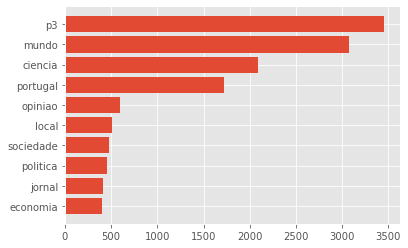

In [273]:
plt.barh(links.category.value_counts().head(10).index,pd.DataFrame(links.category.value_counts().head(10)).iloc[:,0].sort_values())
#important to reinforce that this graph is for all newspapers

Nevertheless, the prior image does not consider the combination of the category and the sub-category. To have a final list with the category and sub-category combined, the next algorithm was developed.

In [274]:
links.head()

,link,newspaper,SDD,JI,categ_index,category,end_index,categ_index2,category2,end_index2
0,http://www.cmjornal.pt/opiniao/detalhe/lingua-...,CMJornal,False,True,"(opiniao, 30)",opiniao,30,"(detalhe, 38)",detalhe,38.0
1,http://www.expresso.pt/africa/presidente-diz-q...,Expresso,True,False,"(africa, 29)",africa,29,,None,NaN
2,http://www.cmjornal.pt/economia/detalhe/mercad...,CMJornal,True,False,"(economia, 31)",economia,31,"(detalhe, 39)",detalhe,39.0
3,http://www.expresso.pt/africa/falham-investime...,Expresso,True,False,"(africa, 29)",africa,29,,None,NaN
4,http://www.expresso.pt/blogues/blog_roupa_para...,Expresso,False,True,"(blogues, 30)",blogues,30,"(blog_roupa_para_lavar, 52)",blog_roupa_para_lavar,52.0


In [275]:
final_category=[]
for i in range(len(links)):
    if links.categ_index2.iloc[i]!=" ":
        final_category.append(str(links.category.iloc[i]+","+links.category2.iloc[i]))
    else:
        final_category.append(links.category.iloc[i])
links["final_category"]=final_category

In [276]:
#example 
links.head()

,link,newspaper,SDD,JI,categ_index,category,end_index,categ_index2,category2,end_index2,final_category
0,http://www.cmjornal.pt/opiniao/detalhe/lingua-...,CMJornal,False,True,"(opiniao, 30)",opiniao,30,"(detalhe, 38)",detalhe,38.0,"opiniao,detalhe"
1,http://www.expresso.pt/africa/presidente-diz-q...,Expresso,True,False,"(africa, 29)",africa,29,,None,NaN,africa
2,http://www.cmjornal.pt/economia/detalhe/mercad...,CMJornal,True,False,"(economia, 31)",economia,31,"(detalhe, 39)",detalhe,39.0,"economia,detalhe"
3,http://www.expresso.pt/africa/falham-investime...,Expresso,True,False,"(africa, 29)",africa,29,,None,NaN,africa
4,http://www.expresso.pt/blogues/blog_roupa_para...,Expresso,False,True,"(blogues, 30)",blogues,30,"(blog_roupa_para_lavar, 52)",blog_roupa_para_lavar,52.0,"blogues,blog_roupa_para_lavar"


In [277]:
#cross check
i=0
for index,link_ in enumerate(links.link):
    cat=str(links.iloc[index].category)
    cat2=str(links.iloc[index].category)
    if (str("/"+cat+"/") not in link_) or (str("/"+cat2+"/") not in link_):
        i+=1
if i ==0:
    print("No problems!")

No problems!


Finally the next block of code was developed to better undersatnd the top words mentioned when approaching both topics and per newspaper.

In [278]:
links_JISDD=links[links.SDD|links.JI]

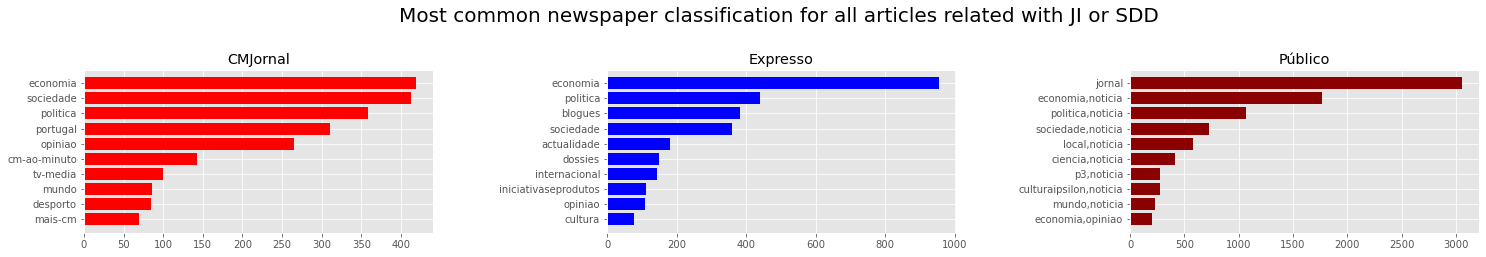

In [279]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(25,3))

color=["red","blue","darkred"]

#------------------------------------------------------------------------------------------------------------------------
links_JISDD_CMJornal=links_JISDD[links_JISDD.newspaper=="CMJornal"]
x_CM_JISDD=links_JISDD_CMJornal.category.value_counts(ascending=False).head(10).index
y_CM_JISDD=links_JISDD_CMJornal.category.value_counts(ascending=False).head(10).values
ax[0].barh(x_CM_JISDD,y_CM_JISDD,color=color[0])
ax[0].set(title="CMJornal")
ax[0].invert_yaxis()

#------------------------------------------------------------------------------------------------------------------------
links_JISDD_Expresso=links_JISDD[links_JISDD.newspaper=="Expresso"]
x_Exp_JISDD=links_JISDD_Expresso.category.value_counts(ascending=False).head(10).index
y_Exp_JISDD=links_JISDD_Expresso.category.value_counts(ascending=False).head(10).values
ax[1].barh(x_Exp_JISDD,y_Exp_JISDD,color=color[1])
ax[1].set(title="Expresso")
ax[1].invert_yaxis()

#------------------------------------------------------------------------------------------------------------------------
links_JISDD_Publico=links_JISDD[links_JISDD.newspaper=="Publico"]
x_Pub_JISDD=links_JISDD_Publico.final_category.value_counts(ascending=False).head(10).index
y_Pub_JISDD=links_JISDD_Publico.final_category.value_counts(ascending=False).head(10).values
ax[2].barh(x_Pub_JISDD,y_Pub_JISDD,color=color[2])
ax[2].set(title="Público")
ax[2].invert_yaxis()
plt.subplots_adjust(wspace=0.5)

fig.text(0.3,1.1,"Most common newspaper classification for all articles related with JI or SDD",fontsize=20)

plt.show()

**Conclusion** - Considering articles sustainability or intergenerational justice related articles, or all articles as an all, it is possible to observe that economic (economia in Portuguese) and politics (politics in Portuguese) related articles are the primary focus of these 3 major Portuguese newspapers. Considering that according to our classification, a great majority of the articles are related to the environment, it is important to understand this divergence to better grasp the editorial focus of Portuguese newspapers.

# Section 4 - Association between SDD and JI topics and Portuguese political parties

Considering that one of the most important components of the political agenda is parties, it is **important to understand how the different political parties are mentioned in traditional media**.

In this section, the goal is to understand the **percentage of articles, per year, that mentioned each party, but also JI or SDD, and respective topics**.


In [280]:
#automatically filtered for obseravtions realted with SDD and JI
data_fig5=datatopics.copy().drop(["lead","title"],axis=1)

In [281]:
data_fig5.columns

Index(['index', 'Time', 'body', 'link', 'year', 'month', 'trimester',
       'body_tokens', 'SDD', 'JI', 'environment', 'debt', 'education',
       'health', 'social_security', 'others', 'politics', 'total'],
      dtype='object')

Considering this new filter, parties, a function was created to **classify each article as associated with a specific party**. **<u>This association is solely dependent on the number of mentions to a specific party</u>**. With this classification, it is intended to know which are the parties that are more mentioned in the articles related to JI or SDD. Being this said, the fact that **some articles will be associated with more than 1 party is not a problem**, as there will cases where the same issue is discussed by different parties. In this case, **to reduce some noise, it was considered a minimum number of occurrences of each party name**, being it the acronym or not, as 2.

In [282]:

def exact_values_per_instances(instance,lists,lists_name,number):
    lists_counter=np.zeros(len(lists_name),dtype=int)
    result=[]
    for name in lists_name:
        counter=0
        #although it would be faster to search the tokens from in list with "lists", due to the case of PAN, explained below,
        #to guarranty a complete analysis the search needs to be per token in the instance
        for word_index,word in enumerate(instance):
            if name!="PAN":
                if word in lists[name]:
                    counter+=1
            else:
                #this specific condition was inserted due to the particulary mention to the movie "peter pan" 
                #that does not refer at all to the political party pan
                if (word in lists[name]) & (instance[word_index-1]!="peter"):
                    counter+=1
        if counter>=number:
            result.append(name)
    return result
        
        
        
  

In [283]:
PS=["ps","socialista"]
PSD=["psd", "social democrata","sociais democratas"]
BE=["be"," bloco esquerda", "bloco de esquerda","bloquista"]
CDS=["cds","cds-pp ","cds-partido popular"]
PCP=["pcp", "cdu", " partido comunista ", "comunistas","partido comunista português"]
PEV=["pev","partido ecologista 'os verdes'"]
PAN=["pan", " partido das dessoas, dos animais e da natureza"]

parties=[PS,PSD,BE,CDS,PCP,PEV,PAN]
parties_name=["PS","PSD","BE","CDS","PCP","PEV","PAN"]

mixed_parties=dict(zip(parties_name,parties))

In [284]:
data_parties=data_fig5.body_tokens.swifter.apply(lambda x:exact_values_per_instances(x,mixed_parties,parties_name,2))


In order to create these new columns to the dataframe, the same procedure/functions used previously with the topics will be applied

In [285]:
data_parties_count=update_database(data_parties,parties_name)

In [286]:
data_parties_count["sum_parties"]=data_parties_count.loc[:,parties_name].sum(axis=1)

In [287]:

data_fig5=pd.merge(data_fig5.drop("index",axis=1).reset_index(),data_parties_count.reset_index(),on="index").set_index("index")
data_fig5.head()


,Time,body,link,year,month,trimester,body_tokens,SDD,JI,environment,...,politics,total,PS,PSD,BE,CDS,PCP,PEV,PAN,sum_parties
index,,,,,,,,,,,,,,,,,,,,,
0,2007-01-03,"impresso do site do jornal correio da manhã, e...",http://www.cmjornal.pt/opiniao/detalhe/lingua-...,2007,1,1,"[impresso, do, site, do, jornal, correio, da, ...",False,True,0,...,0,1,0,0,0,0,0,0,0,0
1,2007-01-05,"na mensagem de ano novo, o presidente da repúb...",http://www.expresso.pt/africa/presidente-diz-q...,2007,1,1,"[na, mensagem, de, ano, novo, ,, o, presidente...",True,False,0,...,0,0,0,0,0,0,0,0,0,0
2,2007-01-07,"impresso do site do jornal correio da manhã, e...",http://www.cmjornal.pt/economia/detalhe/mercad...,2007,1,1,"[impresso, do, site, do, jornal, correio, da, ...",True,False,0,...,0,0,0,0,0,0,0,0,0,0
3,2007-01-08,"""moçambique não tem petróleo, logo não é tão i...",http://www.expresso.pt/africa/falham-investime...,2007,1,1,"[``, moçambique, não, tem, petróleo, ,, logo, ...",True,False,0,...,0,0,0,0,0,0,0,0,0,0
4,2007-01-12,o mundo divide-se em duas partes: os fãs do gu...,http://www.expresso.pt/blogues/blog_roupa_para...,2007,1,1,"[o, mundo, divide-se, em, duas, partes, :, os,...",False,True,0,...,1,0,0,0,0,0,0,0,0,0


As the numerator of the percentage calculated is only referred, again, to articles associated with a topic, it was needed to filter this again.

In [288]:

data_fig5parties=data_fig5[data_fig5.total!=0].loc[:,unpack([topics_name,parties_name,["year"]])]

Since we want to plot the information per party, the data was divided according to the party.

In [289]:
data_fig5parties.columns

Index(['environment', 'debt', 'education', 'health', 'social_security',
       'others', 'politics', 'PS', 'PSD', 'BE', 'CDS', 'PCP', 'PEV', 'PAN',
       'year'],
      dtype='object')

In [290]:
fig5party=[]
for party in parties_name:
    cols_aux=unpack([topics_name,["year"],[str(party)]])
    fig5party.append(data_fig5parties.loc[:,cols_aux].drop("politics",axis=1).copy())

Once again an article needs to be associated with, at least, one party. Therefore, a second filter would need to be created.

In [291]:
# as the goal is to understand out the of articles realted with JI/SDD and with at least one the six topics (excluding politica)
totals=datatopics[datatopics.total!=0].groupby("year").sum().total
fig_15=[]
for party_index,party in enumerate(parties_name):
    party_data=fig5party[party_index]
    
    aux=round((party_data[party_data[party]!=0].groupby("year").sum()).div(totals,axis=0)*100,2)
    
    fig_15.append(aux.fillna(0))
    

<ipython-input-292-a4f39d8792fd>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[fig].set_yticklabels(['{:,.2%}'.format(x) for x in np.arange(0,35,5)/100])
<ipython-input-292-a4f39d8792fd>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[fig].set_yticklabels(['{:,.2%}'.format(x) for x in np.arange(0,35,5)/100])
<ipython-input-292-a4f39d8792fd>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[fig].set_yticklabels(['{:,.2%}'.format(x) for x in np.arange(0,35,5)/100])
<ipython-input-292-a4f39d8792fd>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[fig].set_yticklabels(['{:,.2%}'.format(x) for x in np.arange(0,35,5)/100])
<ipython-input-292-a4f39d8792fd>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[fig].set_yticklabels(['{:,.2%}'.format(x) for x in np.arange(0,35,5)/100])
<ipython-input-292-a4f39d8792fd>:19: Use

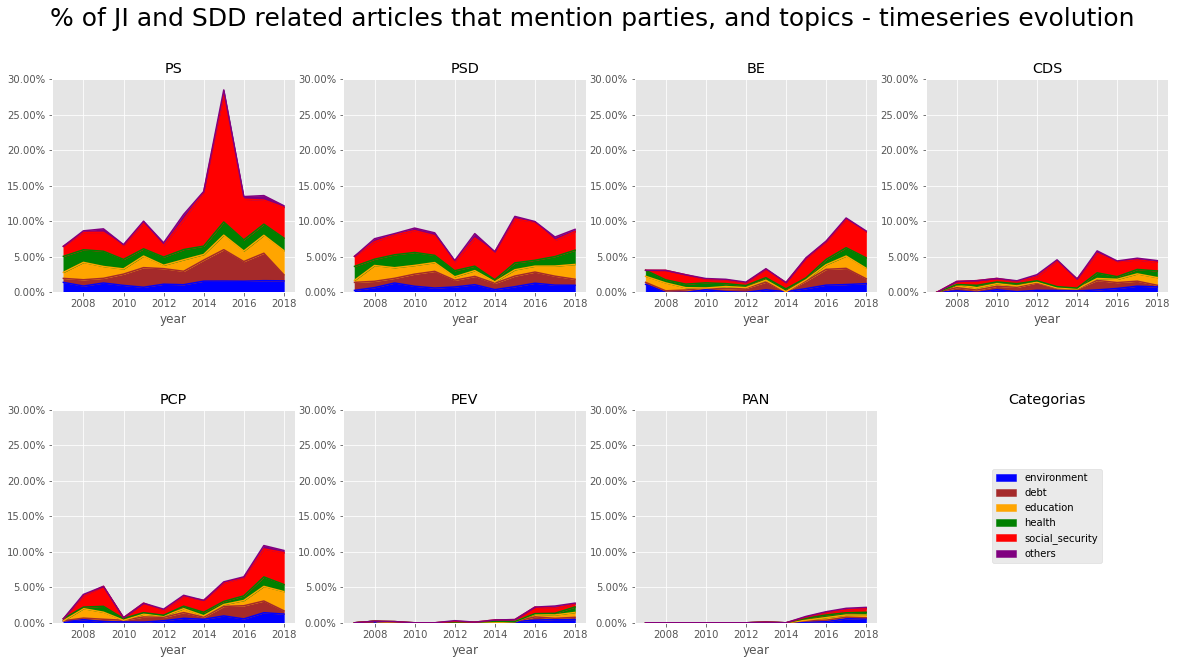

In [292]:
figs,ax=plt.subplots(nrows=2,ncols=4,figsize=(20,10))

color=['blue',"brown","orange","green","red"
,"purple"]

ax=[j for i in ax for j in i]

for fig in range(len(fig_15)):
    #plot data
    pict_categories=list(fig_15[fig].columns[:6])
    category=fig_15[fig].columns[6]
    fig_15[fig][pict_categories].plot.area(ax=ax[fig],stacked=True,color=color)
    
    #arregements on axis and title
    ax[fig].set(title=str(category))
    ax[fig].get_legend().remove()
    vals = ax[fig].get_yticks()
    ax[fig].set_ylim(top=30)
    ax[fig].set_yticklabels(['{:,.2%}'.format(x) for x in np.arange(0,35,5)/100])   
    
    #arregements on lable  
    if fig==len(fig_15)-1:
        handles, labels = ax[fig].get_legend_handles_labels()
        ax[fig+1].set_axis_off()
        legend = ax[fig+1].legend(handles, labels, loc='center')
        ax[fig+1].set(title="Categorias")
        
plt.subplots_adjust(hspace=0.55)
    
figs.suptitle("% of JI and SDD related articles that mention parties, and topics - timeseries evolution",fontsize=25)

plt.show()

# Review title and axes

**Conclusion** - Considering the articles, mentioning political parties as well JI or SDD and their respective topics, one first major conclusion is that parties are normally not mentioned in articles related to the environment, as the environment was the most referred topic when not filtering for articles mentioning to parties. Moreover, there is a clear over mention to the Portuguese socialist party in articles, with a major spike in 2015, the year where PS return to form the Government with BE and PCP, two other left-wing parties, that faced growing mention after it. Nevertheless, when PSD, Portugal's Social Democratic Party, was elected to Government in 2011, the number of articles mentioning PSD did not increase as much as in 2015 with PS, a topic that should be further analyzed.

# Section 5 - Top words mentioned when approaching JI and SDD

Due to several biases that people face, **newspaper articles can unconsciously mention unique words when approaching very specific topics, as SDD or JI**. To understand the signal within all the noise within a newspaper articles, it is **key to filter the noise, normally represented as text elements that are transversally used in all articles**, as punctuation, as commas, and text connectors, as "and", "or", and others. To filter the words according to their grammatical classification, **Part-of-Speech tagging (POS) was applied to the articles**. The signal was considered to be present only in nouns, proper nouns, and adjectives. 

To do the POS, the library **<u>nlpnet and the respective training model, in Portuguese, was imported</u>**.

In [293]:
data_fig7=data.copy().drop(["body_tokens"],axis=1)

In [294]:
tagger = nlpnet.POSTagger("pos-pt",language='pt')

To have a holistic analysis, the POS technique was applied to the 3 different elements of newspaper articles (title, lead, body). For a potential time-series analysis, the year information was also considered.

In [295]:
columns=["body","title","lead"]

In [296]:
for column in columns:
    locals()[str(column)+"POS"]=data_fig7[[str(column),"year","JI","SDD"]].copy()

In [297]:
for column in columns:
    locals()[str(column)+"POS"][str(column)]=locals()[str(column)+"POS"].loc[:,str(column)].swifter.apply(lambda x: tagger.tag(x))

Recalling what was previous mentioned, the signal is not considered in all text elements. Hence, it is key to understand nplnet grammatical classification, represented by several codes:
    - ['PCP', 'PREP+ART', 'N', 'NPROP', 'PU','PREP','ADJ','V','ART','KC','KS','ADV-KS', 'PROPESS']
    
The ones subject to analysis are "N","NPROP" and "ADJ".

Considering the idea proposed initially, a function that selects only the words based on their classification was created and named the top_POS function.
However, it was identified manually that there are cases where propositions are classified as proper nouns because nlpnet develops the classification per token, and in several cases, the intrinsic syntax is associated with a set of words instead. For example, "Ministro das Finanças", in English Finance Minister, the word "das" should be classified, which does not occur, as a proper noun because "Ministro das Finanças" is a proper noun. To account for this case, as for the case of "Primeiro Ministro", in English Prime Minister, manual restrictions were developed in the top_POS function. 

Finally, since the model from nlpnet is not perfect a manual correction needs to be made and so it was observed that some words that appear in the 15 were misclassified and needed to be removed. 

In [298]:
for i in range(len(data_fig7.head(10))):
    if "ministro das finanças" in data_fig7.body.iloc[i]:
        print(i)

6


In [299]:
aux_ex_=unpack(bodyPOS.iloc[6].body)
for i in range(len(aux_ex_)):
    if aux_ex_[i][0]=="ministro":
        print(aux_ex_[i],aux_ex_[i+1],aux_ex_[i+2])
        

('ministro', 'N') ('das', 'PREP+ART') ('finanças', 'N')


In [300]:
for i in range(len(data_fig7.head(10))):
    if "primeiro ministro" in data_fig7.body.iloc[i]:
        print(i)

4


In [301]:
aux_ex_=unpack(bodyPOS.iloc[4].body)
for i in range(len(aux_ex_)):
    if aux_ex_[i][0]=="ministro":
        print(aux_ex_[i-1],aux_ex_[i])
        

('primeiro', 'ADJ') ('ministro', 'N')


To select only the top words, or sets of words as previously stated, considering the syntactic classification, the top_POS function was developed.
Considering our knowledge of the Portuguese language, errors were considered in cases similar to the one previously mentioned, where connectors as "das" should be considered. Other more ad-hoc cases were also considered after an iterative evaluation, as the mention of "Primeiro Ministro".


In [302]:
def specific_cases(first_word, sentence, first_word_index,first_selected_word,second_selected_word):
    if (first_word[0]==first_selected_word)and(sentence[first_word_index+1][0]==second_selected_word):
        output1=(str(first_word[0]+" "+sentence[first_word_index+1][0]))
        output2=(str(first_word[1]+" "+sentence[first_word_index+1][1]))
        return output1,output2
    else:
        pass

In [303]:
specific_cases_pairs=[["primeiro","ministro"],["rui","rio"],["antónio","costa"],["paulo","portas"],["passos","coelho"]]


In [304]:
def top_POS(instance,list_with_classifiers):
    result=[]
    classification=[]
    for phrase_index,phrase in enumerate(instance):
        for item_index,item in enumerate(phrase): 
            #for index_,item_part in enumerate(item):
            try:
                if (item[0] not in ["de","das","da","do","dos"]):
                    if  item[1] in list_with_classifiers:
                        for case in specific_cases_pairs:
                            if item[0] in case[0]:
                                outputs=specific_cases(item,phrase,item_index,case[0],case[1])
                                if outputs!=None:
                                    result.append(outputs[0])
                                    classification.append(outputs[1])
                        else:
                            result.append(item[0])
                            classification.append(item[1])
                
                elif (phrase[item_index-1][1] in list_with_classifiers) and (phrase[item_index+1][1] in list_with_classifiers):
                    prior_word=phrase[item_index-1]
                    word=item
                    next_word=phrase[item_index+1]
                    result.append(str(prior_word[0] + " "+ word[0]+ " "+ next_word[0]))  
                    classification.append(str(prior_word[1] + " "+ word[1]+ " "+ next_word[1]))
            except IndexError:
                continue
    return result, classification


In [305]:
for column in columns:
    aux=locals()[str(column)+"POS"].reset_index().drop("index",axis=1).loc[:,str(column)].apply(lambda x : top_POS(x,["N","NPROP","ADJ"]))
    locals()[str(column)+"_POS_filter"]=pd.DataFrame(index=range(len(aux.index)))
    locals()[str(column)+"_POS_filter"]["words"]=aux.swifter.apply(lambda x:return_slice(x,0))
    locals()[str(column)+"_POS_filter"]["classification"]=aux.swifter.apply(lambda x:return_slice(x,1))
    locals()[str(column)+"_POS_filter"]["JI"]=locals()[str(column)+"POS"]["JI"]
    locals()[str(column)+"_POS_filter"]["SDD"]=locals()[str(column)+"POS"]["SDD"]
    #locals()[str(column)+"_POS_filter"]=pd.DataFrame([aux1,aux2])

To identify the tokens that appear more frequently the function wordsfinal was developed.

In [306]:
def tokensfinal(data):
    aux=[]
    for index_ in range(len(data)):
        aux.append(data.words.iloc[index_])
    value=unpack(aux)
    result=pd.DataFrame(value,columns=["words"]).words.value_counts()
    return result

In [307]:
for column in columns:
    locals()["final_"+str(column)+"POS"]=tokensfinal(locals()[str(column)+"_POS_filter"])


To remove noise that was manually identified to due nlpnet classification errors, the function remove_unimportant_words was developed.

In [308]:
def remove_unimportant_words(series,list_of_words):
    words_aux=list_of_words.copy()
    for word in list_of_words:
        if word not in series.index:
            words_aux.remove(word)
    return series.drop(words_aux)

So far the analysis developed focused on all newspaper articles. Now, it is important to understand the difference between articles mentioning only intergenerational justice or sustainability. 

In [310]:
for column in columns:
    aux=locals()[str(column)+"_POS_filter"][locals()[str(column)+"_POS_filter"].loc[:,["JI","SDD"]].sum(axis=1)!=0]
    locals()["final_"+str(column)+"POS_JISDD"]=tokensfinal(aux)
    

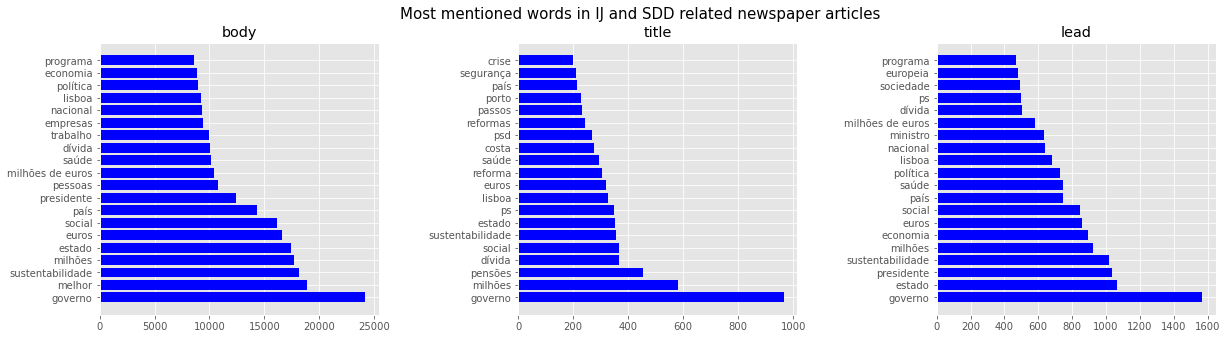

In [311]:
fig_plotJISDD=[]

unimportant_words=["maior","parte","grande","www","tel",'pub','novo','%','anos',
                       'cento','portugal','ano','público','“','”','manhã',
                   'forma','correio','correio da manhã','dia','cm',"h"]

for column in columns:
    fig_plotJISDD.append(remove_unimportant_words(locals()['final_'+str(column)+'POS_JISDD'].head(len(unimportant_words)+10),
                    unimportant_words).head(20))
    
fig,ax=plt.subplots(nrows=1, ncols=3,figsize=(20,5))

for i in range(3):
    #plot data
    ax[i].barh(fig_plotJISDD[i].index,fig_plotJISDD[i],color="blue")
    #arregements on title
    ax[i].set(title=(str(columns[i])))

plt.subplots_adjust(wspace=0.5)
fig.suptitle("Most mentioned words in IJ and SDD related newspaper articles",fontsize=15)
    
plt.show()  

**Conclusion** - Considering the top words mentioned in the articles there is a clear focus on political and economic related news, as government ("governo" in Portuguese), state ("estado" in Portuguese) and euros as 3 of the 6 most mentioned words.

# Section 6 - Top words mentioned when approaching JI and SDD throughout time

The next 3 major figures have the objective to plot the words that higher appearance in the articles. For each figure, the dataset will be divided according to the body, lead and title of the article, and the same analysis as before will be made.



In [313]:
columns=["body","title","lead"]

Since in the previous figure the part-of-speech tagging was already made, now the articles can be divided according to the year they were written.

In [314]:
body_years_POS=[]
for year in range(2007,2019):
        body_years_POS.append(bodyPOS[bodyPOS.year==year])
        
lead_years_POS=[]
for year in range(2007,2019):
        lead_years_POS.append(leadPOS[leadPOS.year==year])
        
title_years_POS=[]
for year in range(2007,2019):
        title_years_POS.append(titlePOS[titlePOS.year==year])
        

From now onwards the code and reasoning applied will be identical for the previous figure.

In [315]:
body_years_POS_filter=[]
years=np.arange(2007,2019)
for i in range(len(body_years_POS)):
    aux=body_years_POS[i].body.apply(lambda x:top_POS(x,[ 'N', 'NPROP', 'ADJ' ]))
    locals()["body_POS_filter"+str(years[i])]=pd.DataFrame(index=aux.index)
    locals()["body_POS_filter"+str(years[i])]["words"]=aux.swifter.apply(lambda x:return_slice(x,0))
    locals()["body_POS_filter"+str(years[i])]["JI"]=body_years_POS[i].JI
    locals()["body_POS_filter"+str(years[i])]["SDD"]=body_years_POS[i].SDD
    body_years_POS_filter.append(locals()["body_POS_filter"+str(years[i])])
    
    
lead_years_POS_filter=[]
years=range(2007,2019)
for i in range(len(lead_years_POS)):
    aux=lead_years_POS[i].lead.apply(lambda x:top_POS(x,[ 'N', 'NPROP', 'ADJ' ]))
    locals()["lead_POS_filter"+str(years[i])]=pd.DataFrame(index=aux.index)
    locals()["lead_POS_filter"+str(years[i])]["words"]=aux.swifter.apply(lambda x:return_slice(x,0))
    locals()["lead_POS_filter"+str(years[i])]["JI"]=lead_years_POS[i].JI
    locals()["lead_POS_filter"+str(years[i])]["SDD"]=lead_years_POS[i].SDD
    lead_years_POS_filter.append(locals()["lead_POS_filter"+str(years[i])])
    

title_years_POS_filter=[]
years=range(2007,2019)
for i in range(len(title_years_POS)):
    aux=title_years_POS[i].title.apply(lambda x:top_POS(x,[ 'N', 'NPROP', 'ADJ' ]))
    locals()["title_POS_filter"+str(years[i])]=pd.DataFrame(index=aux.index)
    locals()["title_POS_filter"+str(years[i])]["words"]=aux.swifter.apply(lambda x:return_slice(x,0))
    locals()["title_POS_filter"+str(years[i])]["JI"]=title_years_POS[i].JI
    locals()["title_POS_filter"+str(years[i])]["SDD"]=title_years_POS[i].SDD
    title_years_POS_filter.append(locals()["title_POS_filter"+str(years[i])])

In [316]:
labels=["words","classification"]

final_body_POS_years=[]
for i in range(len(body_years_POS_filter)):
    aux=body_years_POS_filter[i][body_years_POS_filter[i].loc[:,["JI","SDD"]].sum(axis=1)!=0]
    aux.rename(columns={"body":"words"},inplace=True)
    final_body_POS_years.append(tokensfinal(aux))
    
    
final_title_POS_years=[]
for i in range(len(title_years_POS_filter)):
    aux=title_years_POS_filter[i][title_years_POS_filter[i].loc[:,["JI","SDD"]].sum(axis=1)!=0]
    aux.rename(columns={"title":"words"},inplace=True)
    final_title_POS_years.append(tokensfinal(aux))
    

final_lead_POS_years=[]
for i in range(len(lead_years_POS_filter)):
    aux=lead_years_POS_filter[i][lead_years_POS_filter[i].loc[:,["JI","SDD"]].sum(axis=1)!=0]
    aux.rename(columns={"lead":"words"},inplace=True)
    final_lead_POS_years.append(tokensfinal(aux))
    

C:\Users\franco joao\Anaconda 34\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\franco joao\Anaconda 34\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\franco joao\Anaconda 34\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename

C:\Users\franco joao\Anaconda 34\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\franco joao\Anaconda 34\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\franco joao\Anaconda 34\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename

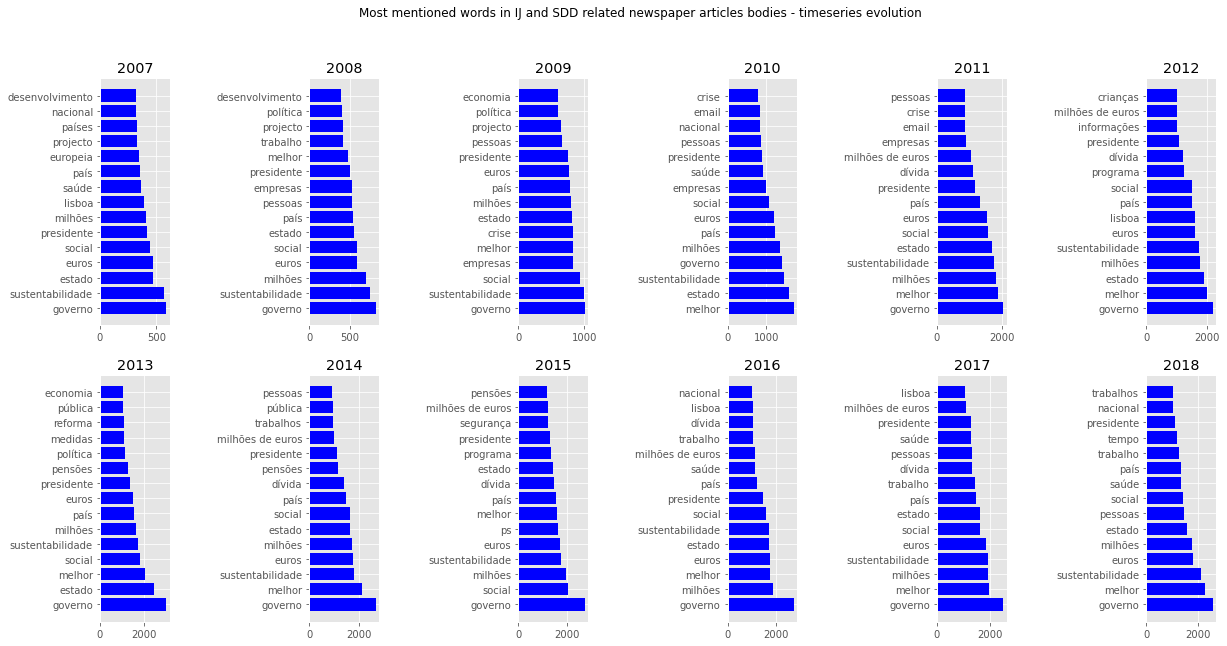

In [317]:
fig,ax=plt.subplots(nrows=2,ncols=6,figsize=(20,10))

years=np.arange(2007,2019)

ax = [j for i in ax for j in i]

for i in range(len(body_years_POS_filter)):
    #prepare data for plot
    unimportant_words=["maior","parte","grande","www","tel",'pub','novo','%','anos',
                       'cento','portugal','ano','público','“','”','manhã',
                   'forma','correio','correio da manhã','dia','cm',"h"]
    fig_plot=remove_unimportant_words(final_body_POS_years[i].head(len(unimportant_words)+20),unimportant_words).head(15)
    #plot data
    ax[i].barh(fig_plot.index,fig_plot,color="blue")
    #arregements of title
    ax[i].set(title=str(years[i]))
    
fig.suptitle("Most mentioned words in IJ and SDD related newspaper articles bodies - timeseries evolution")

plt.subplots_adjust(wspace=2)

plt.show()

In [318]:
fig_plot.index

Index(['governo', 'melhor', 'sustentabilidade', 'euros', 'milhões', 'estado',
       'pessoas', 'social', 'saúde', 'país', 'trabalho', 'tempo', 'presidente',
       'nacional', 'trabalhos'],
      dtype='object')

In [319]:
final_years=[]
for i in range(len(body_years_POS_filter)):
    unimportant_words=["maior","parte","grande","www","tel",'pub','novo','%','anos',
                       'cento','portugal','ano','público','“','”','manhã',
                   'forma','correio','correio da manhã','dia','cm',"h"]
    fig_plot=remove_unimportant_words(final_body_POS_years[i].head(len(unimportant_words)+20),unimportant_words).head(15)
    #plot data
    indexes=list(fig_plot.index)
    if "dívida" in indexes:
        print("dívida was the " + str(indexes.index("dívida")) + " most mentioned word in " + str(years[i]))
    else:
        final_years.append(str(years[i]))
print("")
print("dívida was not in the top 10 words mentioned in " + str(final_years))

dívida was the 9 most mentioned word in 2011
dívida was the 10 most mentioned word in 2012
dívida was the 8 most mentioned word in 2014
dívida was the 8 most mentioned word in 2015
dívida was the 12 most mentioned word in 2016
dívida was the 9 most mentioned word in 2017

dívida was not in the top 10 words mentioned in ['2007', '2008', '2009', '2010', '2013', '2018']


**Conclusion** - Considering the most mentioned words in the body of the articles throughout years, it is possible to observe that word Government (in Portuguese Governo) has been the most mentioned word throughout time. Other interesting conclusion is that sustainability was the second most mentioned term until 2009 and that after that, even with the recovery from the crisis, the term never return to the "position" decreaseing even to 6th place in 2016. Other terms as "debt" (in Portuguese dívida) entered in the top 10th of most mentioned words in 2011, being there until the 2019, with exception of 2013 and 2018. This reinforces the idea that potentially has been a shift in the focus of Portuguese newspaper that should be targeted for furhter analyses.

Below the top 10 words in the leads and titles of articles can be found.

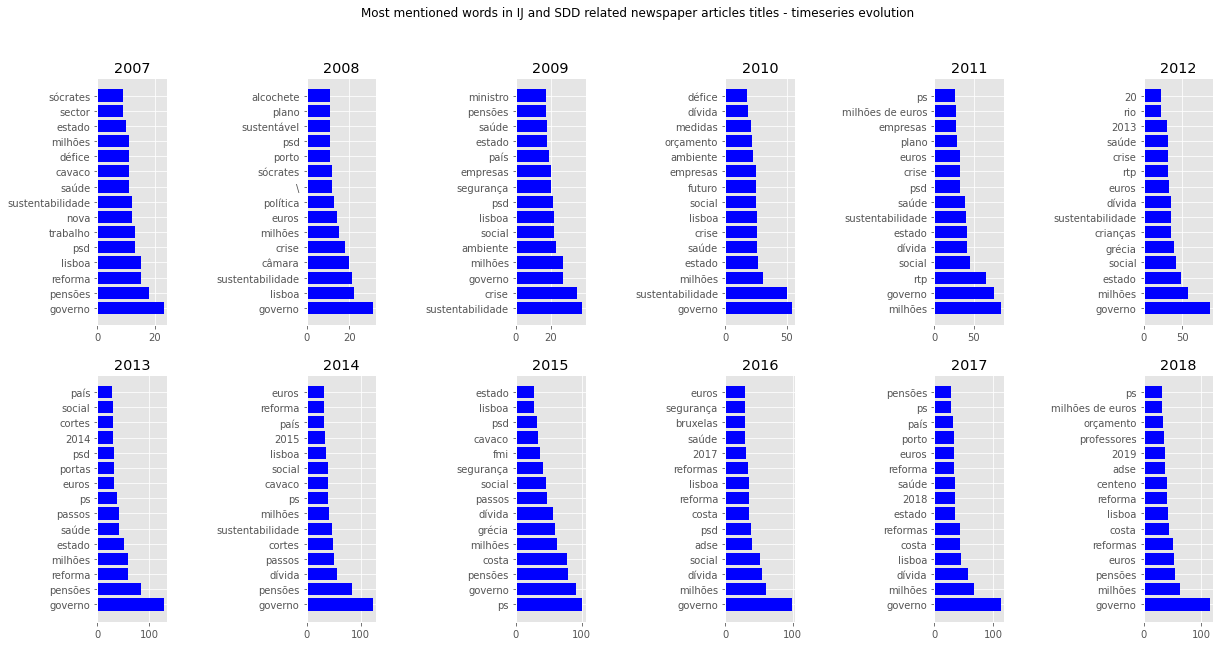

In [320]:
fig,ax=plt.subplots(nrows=2,ncols=6,figsize=(20,10))

years=np.arange(2007,2019)

ax = [j for i in ax for j in i]


for i in range(len(final_title_POS_years)):
    #prepare data for plot
    unimportant_words=['maior','parte','grande','www','tel','pub','novo','%','anos',
                       'cento','portugal','ano','público','“','”','manhã','forma','correio','correio da manhã','dia','cm',
                       'h']
    fig_plot=remove_unimportant_words(final_title_POS_years[i].head(len(unimportant_words)+20),unimportant_words).head(15)
    #plot data
    ax[i].barh(fig_plot.index,fig_plot,color='blue')
    #arregements of title
    ax[i].set(title=str(years[i]))

fig.suptitle('Most mentioned words in IJ and SDD related newspaper articles titles - timeseries evolution')

plt.subplots_adjust(wspace=2)

plt.show()

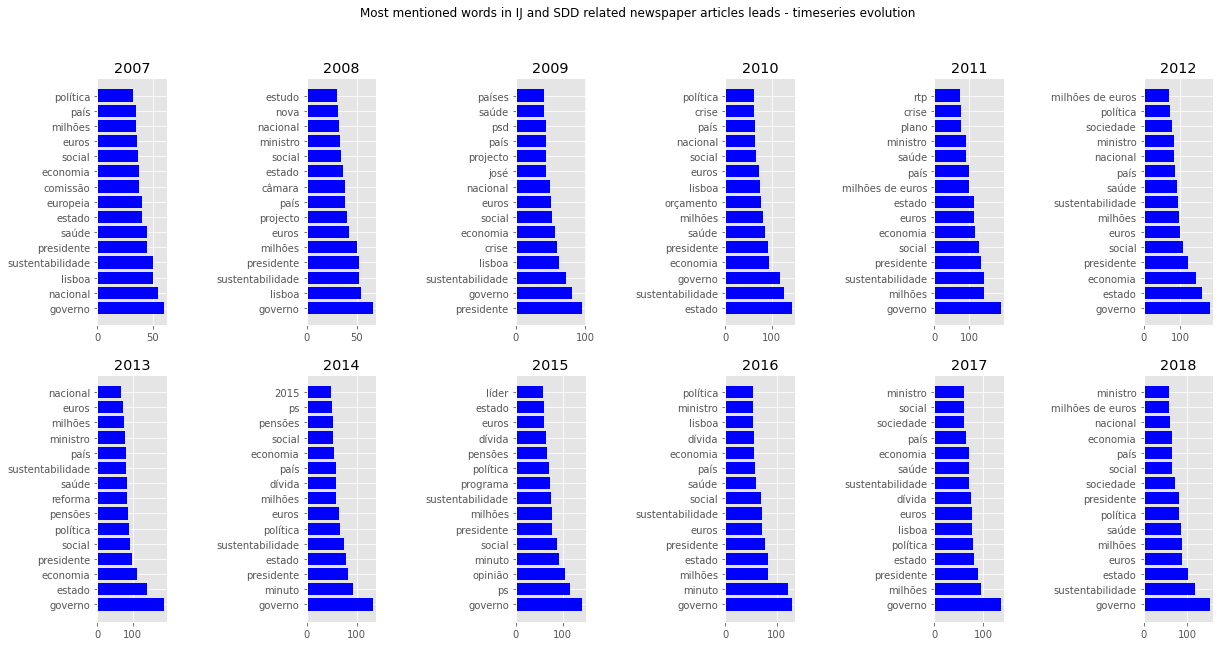

In [321]:
fig,ax=plt.subplots(nrows=2,ncols=6,figsize=(20,10))

years=np.arange(2007,2019)

ax = [j for i in ax for j in i]

for i in range(len(final_lead_POS_years)):
    #prepare data for plot
    unimportant_words=["maior","parte","grande","www","tel",'pub','novo','%','anos',
                       'cento','portugal','ano','público','“','”','manhã',
                   'forma','correio','correio da manhã','dia','cm',"h"]
    fig_plot=remove_unimportant_words(final_lead_POS_years[i].head(len(unimportant_words)+20),unimportant_words).head(15)
    #plot data
    ax[i].barh(fig_plot.index,fig_plot,color="blue")
    #arregements of title
    ax[i].set(title=str(years[i]))

fig.suptitle("Most mentioned words in IJ and SDD related newspaper articles leads - timeseries evolution")

plt.subplots_adjust(wspace=2)

plt.show()

# Section 7 - Differences between political parties

Prior analyses allowed to better understand newspaper developed association of political parties with the identified sustainability and intergenerational justice-related topics.

Nevertheless, with a **<u>principal component analysis (PCA)<u>** is is possible to **understand how the political parties differ from each other.**

With the PCA the goal is to **transpose the 6 dimensions that can characterize each mention to each party**, being each dimension of the related topics, **to a 2-dimension scenario** to then understand the differences across parties.



In [322]:
data7=data_fig5parties

In [323]:
data7.loc[:,"total"]=data7.loc[:,topics_name].sum(axis=1)-data7.politics

The 6 dimensions that describe the parties-topics association are the % of articles that mention a speak party, that mention as well a specific topic, but also internerational justice or sustainability. 

For that the next block of code was developed. Considering that data7 only considers observations realted with IJ or SDD, only the remaining 2 filters needed were applied.

In [324]:
bar_stacked=pd.DataFrame(index=parties_name,columns=topics_name)
for party in parties_name:
    locals()["data7"+str(party)]=data7[(data7.loc[:,str(party)]==1)&(data7.loc[:,"total"]!=0)].loc[:,unpack([topics_name,["total",str(party)]])]
    locals()["data7"+str(party)+"final"]=(locals()["data7"+str(party)].sum(axis=0)/locals()["data7"+str(party)].sum(axis=0).total*100)
    for tema in topics_name:  
        bar_stacked.loc[str(party),tema]=locals()["data7"+str(party)+"final"].loc[tema]
bar_stacked.drop("politics",axis=1,inplace=True)

In [325]:
bar_stacked

,environment,debt,education,health,social_security,others
PS,10.589908,18.763326,13.646055,12.153518,41.791045,3.056148
PSD,10.91314,15.812918,13.585746,14.365256,41.536748,3.786192
BE,11.583012,19.69112,12.934363,14.285714,39.382239,2.123552
CDS,11.640212,17.724868,12.169312,11.904762,42.063492,4.497354
PCP,12.328767,15.582192,16.780822,10.787671,41.438356,3.082192
PEV,18.095238,12.380952,18.095238,16.190476,29.52381,5.714286
PAN,23.170732,9.756098,17.073171,19.512195,21.95122,8.536585


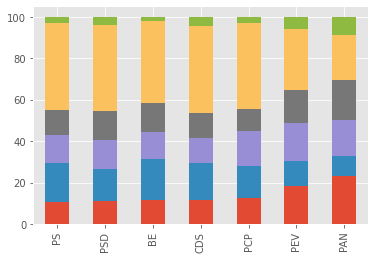

In [326]:
bar_stacked.plot(kind="bar",stacked=True,legend=False)

plt.show()

Having the the six dimensions described for each party, the two component PCA was applied. 

In [327]:
pca = PCA(n_components=2)

In [328]:
pcaed=pd.DataFrame(pca.fit_transform(bar_stacked))
pcaed

,0,1
0,-7.262375,-0.545750
1,-5.304743,-0.065946
2,-5.029338,-3.053404
3,-6.703289,-0.682877
4,-5.049435,3.874242
5,9.650596,1.394962
6,19.698584,-0.921227


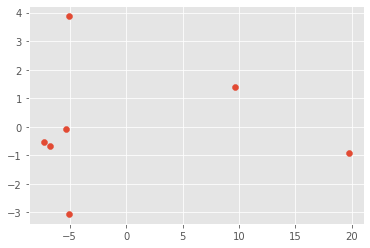

In [329]:
plt.scatter(x=pcaed[0],y=pcaed[1])

In [330]:
pcaed.set_index(bar_stacked.index,inplace=True)
pcaed

,0,1
PS,-7.262375,-0.545750
PSD,-5.304743,-0.065946
BE,-5.029338,-3.053404
CDS,-6.703289,-0.682877
PCP,-5.049435,3.874242
PEV,9.650596,1.394962
PAN,19.698584,-0.921227


In [331]:
colors_parties=['pink',"orange","blue","brown","red","green","lightblue"]
colors=dict(zip(parties_name,colors_parties))

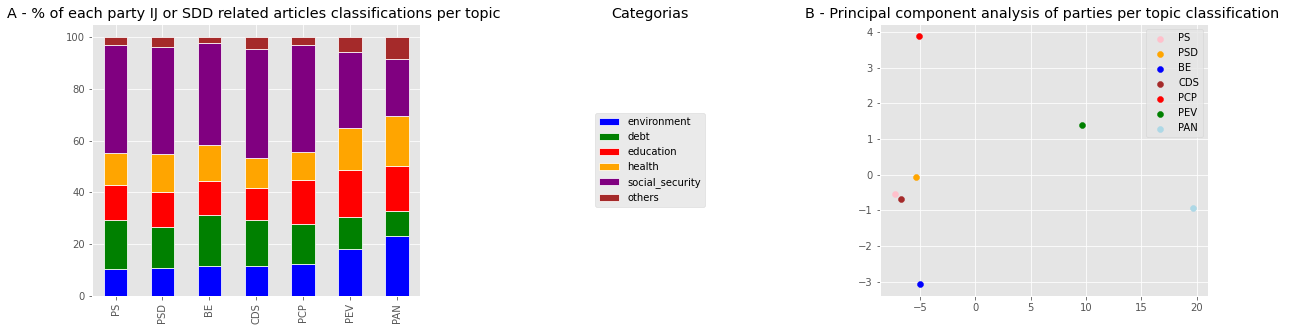

In [332]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
color=['blue',"green","red","orange","purple","brown"]


bar_stacked.plot(ax=ax[0],kind="bar",stacked=True,legend=False,color=color,edgecolor="white",linewidth=0.75)
ax[0].set(title="A - % of each party IJ or SDD related articles classifications per topic ") #there are topics with more than one topic classification


handles, labels = ax[0].get_legend_handles_labels()
ax[1].set_axis_off()
legend=ax[1].legend(handles,topics_name,loc="center")
ax[1].set(title="Categorias")


for i in range(len(pcaed)):
    ax[2].scatter(x=pcaed[0][i],y=pcaed[1][i], c=colors[pcaed.index[i]])
    
ax[2].legend(parties_name,loc="best")
ax[2].set(title="B - Principal component analysis of parties per topic classification ")


plt.show()

**Conclusion 1** - PCA results reveal that Portguese newspaper normally mention PS, CDS and PSD with the same topics, when approching IJ or SDD related topics. This can be highly impacted by the fact that since 2008 until 2015, these parties had governmental positions, while PCP and BE only had after 2015, and so it is not a result that newspaper consider specific topics are related with those specific parties, but just because since they had governmental positions they would be mentioned in the same articles. Therefore, it is important to further explore the driver of this association: governmental position or newspapers really think that PS, PSD and CDS should be mentioned with the same topics, proportionally 

The PCA intended to compress the information present in the 6 dimensions into 2 dimensions, but maintain the most important signal. Analysing the eigenvectors it is possible to understand how the signals from the 6 dimensions most impact the now 2 dimensions.

In [350]:
pd.DataFrame(pca.components_,columns=topics_name[:6])

,environment,debt,education,health,social_security,others
0,0.452624,-0.311678,0.164822,0.258481,-0.753729,0.189479
1,0.066164,-0.532661,0.658860,-0.463350,0.250359,0.020628


**Conclusion 2** - Considering the eigenvectors, the dimension described in the x axis of the previous right hand side graph is mostly influenced by mentions to social security, where a higher the value refers to, on average, lower % of articles mentioning that party a social security topics. 

Regarding the dimension described in the y axis, debt, education and health related topics influence mostly this dimension, with higher values of it associated, ceteris paribus, with either lower values of mention to debt, health or higher mention of articles to education related topics.

All these conclusions are in articles related with IJ or SDD, and despite the prior topics have a higher direct impact on the 2 PCA dimensions, it cannot be concluded that do not impact the result.